In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

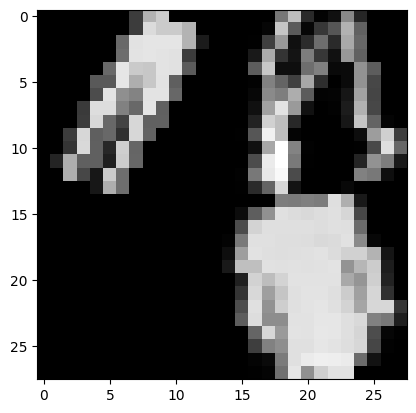

In [ ]:
# Read a pickle file and disply its samples

train_path = '/content/drive/MyDrive/ECSE551/MP3/Train.pkl'
targets_path = '/content/drive/MyDrive/ECSE551/MP3/Train_labels.csv'

data = pickle.load( open( train_path , 'rb' ), encoding='bytes')
targets = np.genfromtxt(targets_path, delimiter=',', skip_header=1)
plt.imshow(data[0,:,:].squeeze(), cmap='gray')
plt.show()

In [ ]:
data[0] # seems already normalized to values between 0-1?

In [ ]:
# Read image data and their label into a Dataset
data = torch.from_numpy(data)
targets = torch.from_numpy(targets)

print(data.shape) # batch size, num of colour channels, row, column
print(targets.shape) # float64

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 2])


In [ ]:
# for normalization
mean = 0.5 #data.mean() # 0.2056
std = 0.5 #data.std() # 0.2942

In [ ]:
# Transforms are common image transformations. They can be chained together using Compose.
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([mean], [std])
])

In [ ]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

from torch.utils.data import Dataset

img_identity = transforms.ToTensor()

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ))
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, dtype=int)[:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index][1])
        #img = Image.fromarray(img.squeeze().astype('uint8'), mode='L')
        #print(img.shape)

        img = torch.from_numpy(img)

        if self.transform is not None:
           img = self.transform(img)
        #print(img.shape)


        return img, target



In [ ]:
# Read image data and their label into a Dataset class
# dataset = MyDataset(train_path, targets_path, transform=img_transform, idx=None)

dataset = MyDataset(train_path, targets_path, idx=None)

In [ ]:
dataset.__getitem__(0) # returns (img_tensor, label)

In [ ]:
batch_size = 200 #feel free to change it (originally 256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Read a batch of data and their labels and display them
# Note that since data are transformed, they are between [-1,1]
imgs, labels = (next(iter(dataloader)))

### split into test and train sets

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

### CNN time

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

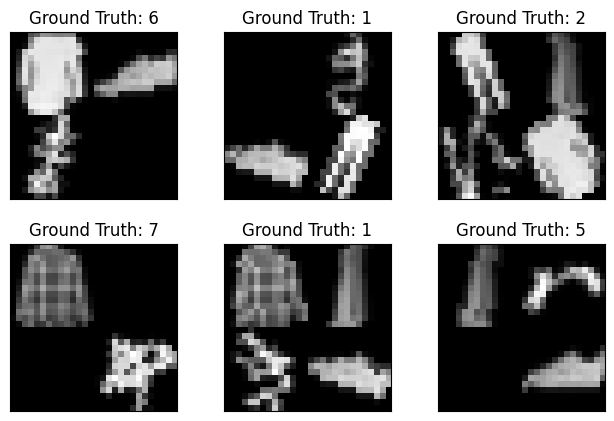

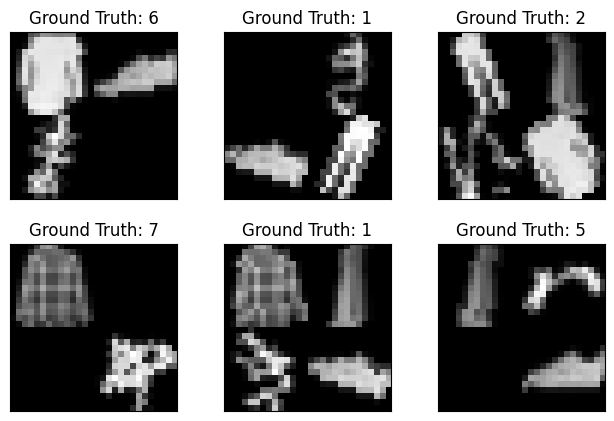

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Then, going from channel size (or feature size) 10 to 20.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Now let us create some feed foreward layers in the end. Remember the sizes (from 320 to 50)
        self.fc1 = nn.Linear(320, 50)
        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):


        # F.relu is ReLU activation. F.max_pool2d is a max pooling layer with n=2
        # Max pooling simply selects the maximum value of each square of size n. Effectively dividing the image size by n
        # At first, x is out input, so it is 1x28x28
        # After the first convolution, it is 10x24x24 (24=28-5+1, 10 comes from feature size)
        # After max pooling, it is 10x12x12
        # ReLU doesn't change the size
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Again, after convolution layer, size is 20x8x8 (8=12-5+1, 20 comes from feature size)
        # After max pooling it becomes 20x4x4
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # This layer is an imaginary one. It simply states that we should see each member of x
        # as a vector of 320 elements, instead of a tensor of 20x4x4 (Notice that 20*4*4=320)
        x = x.view(-1, 320)

        # Feedforeward layers. Remember that fc1 is a layer that goes from 320 to 50 neurons
        x = F.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)

        # We should put an appropriate activation for the output layer.
        return F.log_softmax(x)

In [ ]:
torch.manual_seed(42)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)

scores = []
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  scores.append(int(100. * correct / len(test_loader.dataset)))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 35):
  train(epoch)
  test()

<ipython-input-56-88d9d3b72cc3>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/48000 (0%)]	Loss: 2.304424
Train Epoch: 1 [4000/48000 (8%)]	Loss: 2.304282
Train Epoch: 1 [8000/48000 (17%)]	Loss: 2.296494
Train Epoch: 1 [12000/48000 (25%)]	Loss: 2.298001
Train Epoch: 1 [16000/48000 (33%)]	Loss: 2.286674
Train Epoch: 1 [20000/48000 (42%)]	Loss: 2.154460
Train Epoch: 1 [24000/48000 (50%)]	Loss: 2.107861
Train Epoch: 1 [28000/48000 (58%)]	Loss: 2.035601
Train Epoch: 1 [32000/48000 (67%)]	Loss: 1.922594
Train Epoch: 1 [36000/48000 (75%)]	Loss: 1.757369
Train Epoch: 1 [40000/48000 (83%)]	Loss: 1.537410
Train Epoch: 1 [44000/48000 (92%)]	Loss: 1.585752

Test set: Avg. loss: 1.3690, Accuracy: 6255/12000 (52%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 1.361667
Train Epoch: 2 [4000/48000 (8%)]	Loss: 1.217849
Train Epoch: 2 [8000/48000 (17%)]	Loss: 1.261384
Train Epoch: 2 [12000/48000 (25%)]	Loss: 1.327916
Train Epoch: 2 [16000/48000 (33%)]	Loss: 1.182562
Train Epoch: 2 [20000/48000 (42%)]	Loss: 1.109928
Train Epoch: 2 [24000/48000 (50%)]	Loss: 1.104649
Train Ep

In [ ]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

In [ ]:
for epoch in range(35, 50):
  train(epoch)
  test()

Train Epoch: 35 [0/48000 (0%)]	Loss: 0.314443


<ipython-input-56-88d9d3b72cc3>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 35 [4000/48000 (8%)]	Loss: 0.299575
Train Epoch: 35 [8000/48000 (17%)]	Loss: 0.219117
Train Epoch: 35 [12000/48000 (25%)]	Loss: 0.353651
Train Epoch: 35 [16000/48000 (33%)]	Loss: 0.258476
Train Epoch: 35 [20000/48000 (42%)]	Loss: 0.225303
Train Epoch: 35 [24000/48000 (50%)]	Loss: 0.201085
Train Epoch: 35 [28000/48000 (58%)]	Loss: 0.268170
Train Epoch: 35 [32000/48000 (67%)]	Loss: 0.269272
Train Epoch: 35 [36000/48000 (75%)]	Loss: 0.284453
Train Epoch: 35 [40000/48000 (83%)]	Loss: 0.178892
Train Epoch: 35 [44000/48000 (92%)]	Loss: 0.285849

Test set: Avg. loss: 0.3455, Accuracy: 10725/12000 (89%)

Train Epoch: 36 [0/48000 (0%)]	Loss: 0.155120
Train Epoch: 36 [4000/48000 (8%)]	Loss: 0.215641
Train Epoch: 36 [8000/48000 (17%)]	Loss: 0.242611
Train Epoch: 36 [12000/48000 (25%)]	Loss: 0.278026
Train Epoch: 36 [16000/48000 (33%)]	Loss: 0.190279
Train Epoch: 36 [20000/48000 (42%)]	Loss: 0.250562
Train Epoch: 36 [24000/48000 (50%)]	Loss: 0.211311
Train Epoch: 36 [28000/48000 (58%)

In [ ]:
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [ ]:
for epoch in range(50, 70):
  train(epoch)
  test()

Train Epoch: 50 [0/48000 (0%)]	Loss: 0.162702


<ipython-input-56-88d9d3b72cc3>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 50 [4000/48000 (8%)]	Loss: 0.151014
Train Epoch: 50 [8000/48000 (17%)]	Loss: 0.187278
Train Epoch: 50 [12000/48000 (25%)]	Loss: 0.229016
Train Epoch: 50 [16000/48000 (33%)]	Loss: 0.164941
Train Epoch: 50 [20000/48000 (42%)]	Loss: 0.108474
Train Epoch: 50 [24000/48000 (50%)]	Loss: 0.179618
Train Epoch: 50 [28000/48000 (58%)]	Loss: 0.174758
Train Epoch: 50 [32000/48000 (67%)]	Loss: 0.176732
Train Epoch: 50 [36000/48000 (75%)]	Loss: 0.150415
Train Epoch: 50 [40000/48000 (83%)]	Loss: 0.161520
Train Epoch: 50 [44000/48000 (92%)]	Loss: 0.217148

Test set: Avg. loss: 0.3297, Accuracy: 10763/12000 (90%)

Train Epoch: 51 [0/48000 (0%)]	Loss: 0.132738
Train Epoch: 51 [4000/48000 (8%)]	Loss: 0.174825
Train Epoch: 51 [8000/48000 (17%)]	Loss: 0.180367
Train Epoch: 51 [12000/48000 (25%)]	Loss: 0.222446
Train Epoch: 51 [16000/48000 (33%)]	Loss: 0.167616
Train Epoch: 51 [20000/48000 (42%)]	Loss: 0.111440
Train Epoch: 51 [24000/48000 (50%)]	Loss: 0.161418
Train Epoch: 51 [28000/48000 (58%)

In [ ]:
optimizer = optim.SGD(network.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.001)

In [ ]:
for epoch in range(70, 100):
  train(epoch)
  test()

Train Epoch: 70 [0/48000 (0%)]	Loss: 0.133026


<ipython-input-56-88d9d3b72cc3>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 70 [4000/48000 (8%)]	Loss: 0.153862
Train Epoch: 70 [8000/48000 (17%)]	Loss: 0.172344
Train Epoch: 70 [12000/48000 (25%)]	Loss: 0.129185
Train Epoch: 70 [16000/48000 (33%)]	Loss: 0.218297
Train Epoch: 70 [20000/48000 (42%)]	Loss: 0.147899
Train Epoch: 70 [24000/48000 (50%)]	Loss: 0.169133
Train Epoch: 70 [28000/48000 (58%)]	Loss: 0.115460
Train Epoch: 70 [32000/48000 (67%)]	Loss: 0.150792
Train Epoch: 70 [36000/48000 (75%)]	Loss: 0.220070
Train Epoch: 70 [40000/48000 (83%)]	Loss: 0.111813
Train Epoch: 70 [44000/48000 (92%)]	Loss: 0.124823

Test set: Avg. loss: 0.3307, Accuracy: 10754/12000 (90%)

Train Epoch: 71 [0/48000 (0%)]	Loss: 0.165082
Train Epoch: 71 [4000/48000 (8%)]	Loss: 0.154741
Train Epoch: 71 [8000/48000 (17%)]	Loss: 0.130743
Train Epoch: 71 [12000/48000 (25%)]	Loss: 0.179925
Train Epoch: 71 [16000/48000 (33%)]	Loss: 0.143686
Train Epoch: 71 [20000/48000 (42%)]	Loss: 0.102255
Train Epoch: 71 [24000/48000 (50%)]	Loss: 0.124013
Train Epoch: 71 [28000/48000 (58%)

In [ ]:
scores

[52,
 73,
 77,
 80,
 81,
 82,
 84,
 83,
 82,
 83,
 84,
 84,
 83,
 84,
 84,
 85,
 86,
 85,
 86,
 85,
 85,
 86,
 86,
 86,
 86,
 86,
 85,
 86,
 87,
 86,
 86,
 86,
 87,
 86,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89,
 89]

Text(0, 0.5, 'cross entropy loss loss')

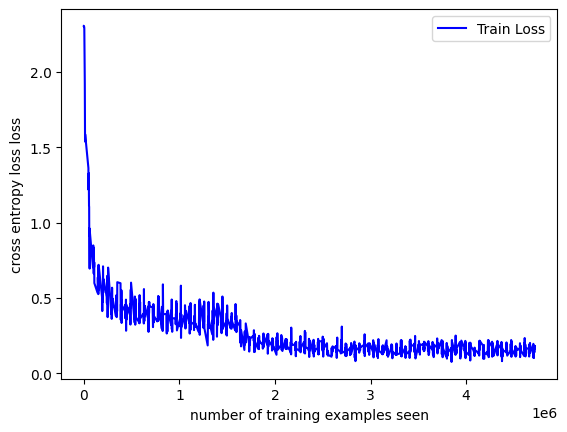

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')
# fig

Text(0, 0.5, 'Accuracy score')

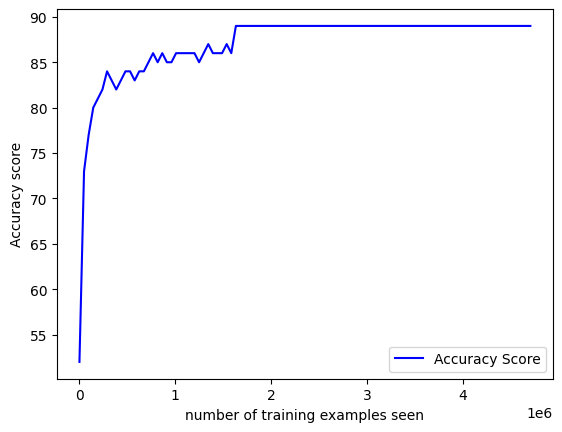

In [ ]:
x = train_counter[::int(len(train_counter)/len(scores))]
fig = plt.figure()
plt.plot(x, scores, color='blue')
plt.legend(['Accuracy Score'], loc='lower right')
plt.xlabel('number of training examples seen')
plt.ylabel('Accuracy score')
# fig

In [ ]:
final_path = '/content/drive/MyDrive/ECSE551/MP3/Test.pkl'

final_dataset = pickle.load( open( final_path , 'rb' ), encoding='bytes')

final_loader = DataLoader(final_dataset, batch_size=200)

In [ ]:
final_dataset.shape

(10000, 1, 28, 28)

In [ ]:
# checking to see if final tests loaded right
examples = enumerate(final_loader)
batch_idx, (example_data) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Example: {}".format(i))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
predictions = []
counter = 0
with torch.no_grad():
    for data in final_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      predictions.append(pred)
      counter += 1

temp = []
for e in predictions:
  for t in e.flatten():
    temp.append(int(t))

<ipython-input-56-88d9d3b72cc3>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
temp = []
for p in predictions:
  for t in p:
    temp.append(int(t))


In [ ]:
import csv

''' function to make a csv file for Kaggle submission '''
def make_csv(predictions):
  with open("./results.csv", "w") as f:
    f.write('id,class\n')
    for i in range(len(predictions)):
      f.write(str(i)+','+ str(temp[i]))
      f.write('\n')

  f.close()

In [ ]:
make_csv(temp)